In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score


C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
import random


In [53]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if tf.config.experimental.list_physical_devices('GPU') else 'cpu'
    lstm_state_path = './data/mitbih/lstm.pth'
    
    lstm_logs = './data/mitbih/lstm.csv'
    
    train_csv_path = './data/mitbih_train.csv'
    test_csv_path = './data/mitbih_test.csv'

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    if tf.config.experimental.list_physical_devices('GPU'):
        tf.random.set_seed(seed)

config = Config()
seed_everything(config.seed)


In [6]:
df_ptbdb = pd.read_csv('./data/ptbdb_abnormal.csv')
df_mitbih = pd.read_csv('./data/mitbih_train.csv')
df_ptbdb

,9.322328567504882812e-01,8.696785569190979004e-01,8.861859440803527832e-01,9.296264052391052246e-01,9.087749719619750977e-01,9.339704513549804688e-01,8.010425567626953125e-01,7.497828006744384766e-01,6.872285008430480957e-01,6.350998878479003906e-01,...,0.000000000000000000e+00.117,0.000000000000000000e+00.118,0.000000000000000000e+00.119,0.000000000000000000e+00.120,0.000000000000000000e+00.121,0.000000000000000000e+00.122,0.000000000000000000e+00.123,0.000000000000000000e+00.124,0.000000000000000000e+00.125,1.000000000000000000e+00.1
0,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.925265,0.433352,0.073620,0.079197,0.136643,0.182934,0.182934,0.182376,0.196877,0.203569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10500,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10501,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10502,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10503,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [34]:
df_mitbih_train = pd.read_csv('./data/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv('./data/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 158.7+ MB
None


In [8]:
df_mitbih.to_csv('data.csv', index=False)
config.csv_path = 'data.csv'

## Data Analysis

In [9]:
df_mitbih = pd.read_csv(config.csv_path)
df_mitbih['label'].value_counts()

Normal                               90589
Fusion of paced and normal            8039
Premature ventricular contraction     7236
Artial Premature                      2779
Fusion of ventricular and normal       803
Name: label, dtype: int64

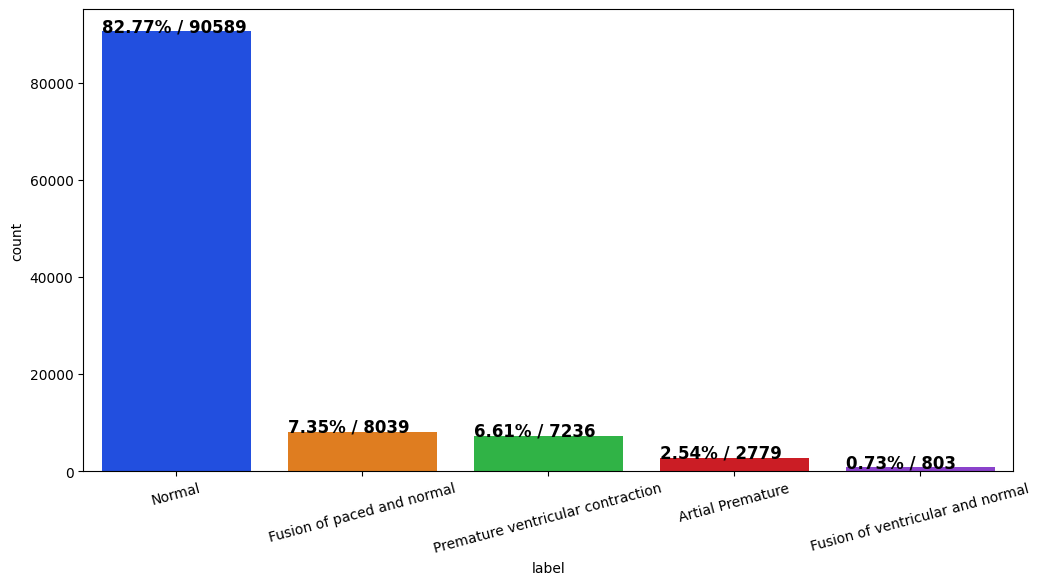

In [35]:
percentages = [count / df_mitbih.shape[0] * 100 for count in df_mitbih['label'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=df_mitbih['label'],
    ax=ax,
    palette="bright",
    order=df_mitbih['label'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
    percentages,
    df_mitbih['label'].value_counts(sort=True).values,
    ax.patches):
    
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')
    
plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('data_dist.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

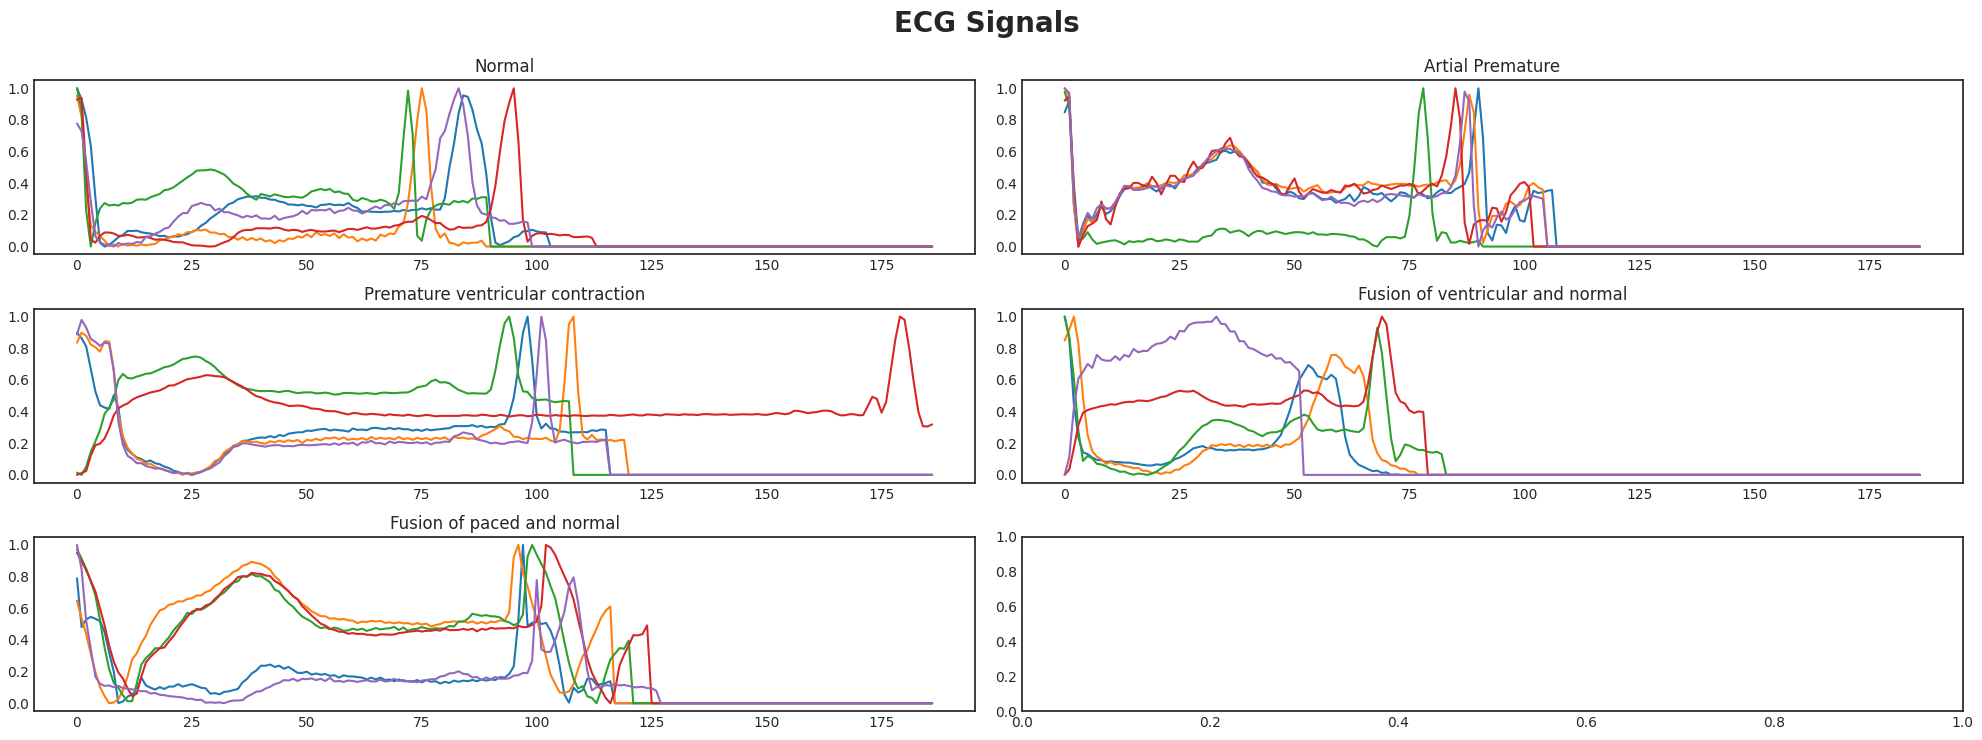

In [36]:
N = 5
samples = [df_mitbih.loc[df_mitbih['class'] == cls].sample(N) for cls in range(N)]
titles = [id_to_label[cls] for cls in range(5)]

with plt.style.context("seaborn-white"):
    fig, axs = plt.subplots(3, 2, figsize=(20, 7))
    for i in range(5):
        ax = axs.flat[i]
        ax.plot(samples[i].values[:,:-2].transpose())
        ax.set_title(titles[i])
        #plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.suptitle("ECG Signals", fontsize=20, y=1.05, weight="bold")
    plt.savefig(f"signals_per_class.svg",
                    format="svg",bbox_inches='tight', pad_inches=0.2)
        
    plt.savefig(f"signals_per_class.png", 
                    format="png",bbox_inches='tight', pad_inches=0.2) 

In [12]:
%%time
signals = [' '.join(df_mitbih.iloc[i, :-1].apply(str).values) for i in range(df_mitbih.shape[0])]
y = df_mitbih.iloc[:, -1].values.tolist()
print(len(signals), len(y))

print(f'data has {len(set([sig for line in signals for sig in line.split()]))} out of 16 372 411 unique values.')

109446 109446
data has 279149 out of 16 372 411 unique values.
Wall time: 53.7 s


In [59]:
df_mitbih_train = pd.read_csv('./data/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv('./data/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 158.7+ MB
None


In [37]:
class ECGDataset(tf.keras.utils.Sequence):
    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32').values
        signal = np.expand_dims(signal, axis=0)
        target = np.array(self.df.loc[idx, 'class'])
        return signal, target

    def __len__(self):
        return len(self.df)


In [60]:
def get_dataloader(phase: str, batch_size: int = 96) -> tf.data.Dataset:
    '''
    Dataset and DataLoader.
    Parameters:
        phase: training or validation phase.
        batch_size: data per iteration.
    Returns:
        data generator
    '''
    df = pd.read_csv(config.train_csv_path)
    train_df, val_df = train_test_split(
        df, test_size=0.15, random_state=config.seed, stratify=df['label']
    )
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    df = train_df if phase == 'train' else val_df
    dataset = ECGDataset(df)
    dataloader = tf.data.Dataset.from_generator(
        lambda: dataset,
        output_types=(tf.float32, tf.int64),
        output_shapes=([None, len(dataset.data_columns)], [])
    )
    dataloader = dataloader.batch(batch_size)
    return dataloader
config.train_csv_path = './data/mitbih_train.csv'


## Model


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



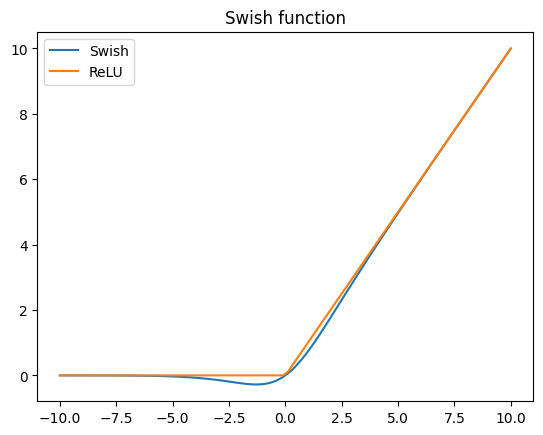

In [15]:
class Swish(tf.keras.layers.Layer):
    def call(self, inputs):
        return inputs * tf.sigmoid(inputs)

x = np.linspace(-10.0, 10.0, 100)
swish = Swish()
swish_out = swish(x)
relu_out = tf.nn.relu(x)

plt.title('Swish function')
plt.plot(x, swish_out, label='Swish')
plt.plot(x, relu_out, label='ReLU')
plt.legend()
plt.show()


In [39]:
class ConvNormPool(tf.keras.layers.Layer):
    """Conv Skip-connection module"""
    def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='batchnorm'
    ):
        super(ConvNormPool, self).__init__()
        
        self.kernel_size = kernel_size
        self.conv_1 = tf.keras.layers.Conv1D(
            filters=hidden_size,
            kernel_size=kernel_size,
            padding='same'
        )
        self.conv_2 = tf.keras.layers.Conv1D(
            filters=hidden_size,
            kernel_size=kernel_size,
            padding='same'
        )
        self.conv_3 = tf.keras.layers.Conv1D(
            filters=hidden_size,
            kernel_size=kernel_size,
            padding='same'
        )
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        if norm_type == 'group':
            self.normalization_1 = tf.keras.layers.LayerNormalization()
            self.normalization_2 = tf.keras.layers.LayerNormalization()
            self.normalization_3 = tf.keras.layers.LayerNormalization()
        else:
            self.normalization_1 = tf.keras.layers.BatchNormalization()
            self.normalization_2 = tf.keras.layers.BatchNormalization()
            self.normalization_3 = tf.keras.layers.BatchNormalization()
            
        self.pool = tf.keras.layers.MaxPooling1D(pool_size=2)
        
    def call(self, inputs):
        conv1 = self.conv_1(inputs)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = tf.pad(x, paddings=[[0, 0], [self.kernel_size - 1, 0], [0, 0]])
        
        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = tf.pad(x, paddings=[[0, 0], [self.kernel_size - 1, 0], [0, 0]])
        
        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_3(x)
        x = tf.pad(x, paddings=[[0, 0], [self.kernel_size - 1, 0], [0, 0]])   
        
        x = self.pool(x)
        return x


In [40]:
class CNN(tf.keras.Model):
    def __init__(
        self,
        input_size = 1,
        hid_size = 256,
        kernel_size = 5,
        num_classes = 5,
    ):
        
        super().__init__()
        
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size//2,
            kernel_size=kernel_size,
        )
        self.conv3 = ConvNormPool(
            input_size=hid_size//2,
            hidden_size=hid_size//4,
            kernel_size=kernel_size,
        )
        self.avgpool = tf.keras.layers.GlobalAveragePooling1D()
        self.fc = tf.keras.layers.Dense(units=num_classes, activation='softmax')
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        x = self.fc(x)
        return x


In [46]:
class BiRNN(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BiRNN, self).__init__()
        self.forward_rnn = tf.keras.layers.LSTM(units, return_sequences=True)
        self.backward_rnn = tf.keras.layers.LSTM(units, return_sequences=True, go_backwards=True)
    
    def call(self, inputs):
        forward_output = self.forward_rnn(inputs)
        backward_output = self.backward_rnn(inputs)
        return tf.keras.layers.concatenate([forward_output, backward_output], axis=-1)


In [50]:
class RNNModel(tf.keras.Model):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()
            
        self.rnn_layer = BiRNN(hid_size)
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = tf.keras.layers.GlobalAveragePooling1D()
        self.fc = tf.keras.layers.Dense(units=n_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.rnn_layer(x)
        x = self.avgpool(x)
        x = self.fc(x)
        return x


In [48]:
class RNNModel(tf.keras.Model):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()
            
        self.rnn_layer = BiRNN(hid_size)
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = tf.keras.layers.GlobalAveragePooling1D()
        self.fc = tf.keras.layers.Dense(units=n_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x, _ = self.rnn_layer(x)
        x = self.avgpool(x)
        x = self.fc(x)
        return x


## Training

In [43]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = np.zeros((n_classes, n_classes))
    
    def update(self, x, y, loss):
        x = np.argmax(x.numpy(), axis=1)
        y = y.numpy()
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x, y)
        self.metrics['f1'] += f1_score(x, y, average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x, y, average='macro', zero_division=1)
        
        self._compute_cm(x, y)
        
    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1
    
    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0
        
    def get_metrics(self):
        return self.metrics
    
    def get_confusion_matrix(self):
        return self.confusion


In [51]:
class Trainer:
    def __init__(self, net, lr, batch_size, num_epochs):
        self.net = net
        self.num_epochs = num_epochs
        self.criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.scheduler = tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 5e-6 + (lr - 5e-6) * (1 - epoch / num_epochs)
        )
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()
    
    def _train_epoch(self, phase):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")



In [61]:
# Define your RNNModel using TensorFlow/Keras layers
model = RNNModel(input_size=1, hid_size=64, rnn_type='lstm', bidirectional=True)

# Create an instance of the Trainer class
trainer = Trainer(net=model, lr=1e-3, batch_size=96, num_epochs=4)

# Run the training loop
trainer.run()


KeyError: 'label'

In [63]:
# Read data and preprocess
df = pd.read_csv('./data/mitbih_train.csv', header=None)
df_test = pd.read_csv('./data/mitbih_test.csv', header=None)
df = pd.concat([df, df_test], axis=0)
df.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df['label'] = df['class'].map(id_to_label)

# Define your RNNModel using TensorFlow/Keras layers
model = RNNModel(input_size=1, hid_size=64, rnn_type='lstm', bidirectional=True)

# Create an instance of the Trainer class
trainer = Trainer(net=model, lr=1e-3, batch_size=96, num_epochs=4)

# Run the training loop
trainer.run()


KeyError: 'label'